##Actualizar YahooFinance a última versión

In [459]:
pip install yfinance --upgrade

##Importar librerías

In [460]:
import pandas as pd, yfinance as yf, pytz, seaborn as sns, matplotlib.pyplot as plt
from datetime import datetime, timedelta
print('proceso terminado!'.upper())

PROCESO TERMINADO!


##Cláusulas para identificar tickers

In [461]:
# Opciones de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('future.no_silent_downcasting', True)

# Crear una consulta para obtener las acciones que han cambiado su valor en los últimos 5 minutos
q = yf.EquityQuery('and', [
    yf.EquityQuery('eq', ['region', 'us']), # Acciones de la región de EE. UU. | eq: equal
    # yf.EquityQuery('is-in', ['exchange', 'NMS', 'NYQ']),
    yf.EquityQuery('gt', ['avgdailyvol3m', 2000000]),  # Cambio porcentual mayor que 0
    yf.EquityQuery('btwn', ['intradayprice', 4.9, 25.9]), # btwn: between
    # yf.EquityQuery('lte', ['intradayprice', 25.9]), # lt: lower than
    # yf.EquityQuery('gte', ['intradayprice', 4.9]), # gt: greater than
    yf.EquityQuery('gt', ['percentchange', 3.1])
    # yf.EquityQuery('lte', ['percentchange', -8.99])
])

# Obtener los datos de las acciones que cumplen con la consulta
# response = yf.screen(q, size= 250,sortField='intradayprice', sortAsc=True)
response = yf.screen(q, size= 250,sortField='percentchange', sortAsc=False)

# Convertir la respuesta a un DataFrame
df = pd.DataFrame(response)
# print(df.shape)
# print(df.to_string())

# Convertir la columna quotes a un DataFrame
quotes_df = pd.DataFrame(df['quotes'].tolist())

# Concatenar el DataFrame original con el nuevo DataFrame de quotes
df = pd.concat([df, quotes_df], axis=1)

# Eliminar la columna quotes original
df = df.drop('quotes', axis=1)
# print(df.columns)

# Resetear el índice
#df = df.reset_index()

df = df[['regularMarketTime','symbol','displayName','longName','regularMarketPrice','regularMarketChangePercent','fiftyTwoWeekRange','fiftyDayAverage','averageDailyVolume3Month','quoteType','financialCurrency', 'marketCap','regularMarketVolume']]
df['prop_volumen'] = df['regularMarketVolume'] / df['averageDailyVolume3Month']

# df = df.query("(regularMarketPrice >= 2 & regularMarketPrice <= 30) & financialCurrency == 'USD' & quoteType == 'EQUITY' & marketCap >= 300000000 & prop_volumen >= 0.6")
# df = df.query("financialCurrency == 'USD' & quoteType == 'EQUITY' & marketCap >= 95000000 & & regularMarketVolume >= 999999 & prop_volumen >= 0.1").reset_index()
# df = df.query("financialCurrency == 'USD' & quoteType == 'EQUITY' & regularMarketPrice > fiftyDayAverage").reset_index()
df = df.query("financialCurrency == 'USD' & quoteType == 'EQUITY'").reset_index()

# Convertir campos
df['regularMarketTime'] = pd.to_datetime(df['regularMarketTime'], unit='s', utc=True).dt.tz_convert('America/New_York') # Convertir a la zona horaria de Nueva York
df['marketCap'] = df['marketCap'].astype(int)

# print(df.shape)
# print(df.dtypes)

# Eliminar valores de la lista
stock_buscar = df['symbol'].tolist()
# stock_buscar = ['AMZN','MSTR','TSLA']
# valores_eliminar = ['AAIGF','BPAQF','ALTM','CSCCF','GLCNF','SSLZY','MUI','GSAT']
valores_eliminar = ['AAIGF','BPAQF','ALTM','CSCCF','GLCNF','SSLZY','MUI','GSAT','SBH','WKEY','OMI','DV','SITC','FLO','IDAI','KNWND','BHC','DENN','FNMA','PPCB']
for valor in valores_eliminar:
    if valor in stock_buscar:
        stock_buscar.remove(valor)

# Validar
print(df.head(10).to_string())
print(f"Total: {len(stock_buscar)} | Nombre de instrumento: {stock_buscar}")
print('proceso terminado!'.upper())

   index         regularMarketTime symbol                   displayName                            longName  regularMarketPrice  regularMarketChangePercent fiftyTwoWeekRange  fiftyDayAverage  averageDailyVolume3Month quoteType financialCurrency   marketCap  regularMarketVolume  prop_volumen
0      0 2025-03-07 16:00:01-05:00   DWTX          Dogwood Therapeutics          Dogwood Therapeutics, Inc.                6.60                   48.984203      1.62 - 29.28         6.164200                   2706057    EQUITY               USD     8792388             25766272      9.521703
1      1 2025-03-06 15:00:00-05:00   PPCB             Propanc Biopharma             Propanc Biopharma, Inc.                7.00                   24.777180   4.0E-4 - 145.46         4.494856                   2983323    EQUITY               USD      107604                    3      0.000001
2      2 2025-03-07 16:00:02-05:00     GV                           NaN             Visionary Holdings Inc.                6

##Descargar y formatear datos
*A las 10:35 se identifican mejor los ganadores del día x tendencia*

In [462]:
# Establecer la zona horaria de Nueva York
nueva_york = pytz.timezone('America/New_York')

# Establecer la fecha y hora de inicio y fin
start = datetime(2025, 3, 7, 0, 0, 0, tzinfo=nueva_york) # Año, Mes, Día, Hora, Minuto, Segundo, Zona horaria
# end = datetime.now()

# Restar 200 días a la fecha de hoy
# start = datetime.now(nueva_york) - timedelta(days=200)
# end = datetime(2025, 2, 21, 10, 20, 0, tzinfo=nueva_york) # A las 10:19 se identifican mejor las tendencias
end = datetime(2025, 3, 7, 11, 34, 0, tzinfo=nueva_york) # A las 9:49 primer reporte 15m | + 4 min para validar período 15m

#end = datetime.now() - timedelta(days=3) # Para ayer

# Crear un DataFrame vacío
df_final = pd.DataFrame(columns=['Ticker', 'Fecha', 'Close', 'Volume', 'High', 'Low', '%_cambio'])

# Crear un DataFrame vacío para almacenar los resultados de cambio_jornada
df_cambio_jornada = pd.DataFrame(columns=['Ticker', 'Cambio_Jornada'])

for a in stock_buscar:
    try:
        data = yf.download(tickers=a, start=start, end=end, interval="15m")
        print(f"\nData collection successful for: {a}")
    except:
        print("Failure in download")

    df1 = pd.DataFrame(data)

    # df1.index = df1.index.tz_localize(nueva_york)  # Comentado!
    df1.index = df1.index.tz_convert(nueva_york)  # Comentado!

    # Resetear el índice
    df1 = df1.reset_index()

    df1.columns = ['Fecha', 'Close', 'High', 'Low', 'Open', 'Volume']
    df1 = df1[['Fecha', 'Close', 'High', 'Low','Volume']]
    df1['Ticker'] = a

    # # Agregar columna para indicar si se cumple la condición de compra
    # df1['Compra'] = False

    # # Iterar sobre los grupos de tres filas
    # df1['Compra'] = False

    # # Iterar sobre los grupos de tres filas
    # for i in range(len(df1) - 2):
    #     if df1['Ticker'].iloc[i] == df1['Ticker'].iloc[i + 1] == df1['Ticker'].iloc[i + 2]:
    #         if df1['Close'].iloc[i+2] >= df1['Close'].iloc[i+1] and df1['Close'].iloc[i+2] > df1['Close'].iloc[i]:
    #             df1.loc[i + 2, 'Compra'] = True

    df1['%_cambio'] = round(df1['Close'].pct_change() * 100,3)
    df1['High'] = round(df1['High'],3)
    df1['Low'] = round(df1['Low'],3)
    df1['Close'] = round(df1['Close'],3)

    # Agregar resultado a df_final
    df_final = pd.concat([df_final.dropna(how='all'), df1.dropna(how='all')], ignore_index=True)

    # Agregar resultado a df_cambio_jornada
    cambio_jornada = round(df1.groupby('Ticker')['%_cambio'].sum(), 2)
    df_cambio_jornada = pd.concat([df_cambio_jornada.dropna(how='all'), pd.DataFrame({'Ticker': [a], 'Cambio_Jornada': [cambio_jornada.iloc[0]]})], ignore_index=True)

# Mensaje
print('proceso terminado!'.upper())

[*********************100%***********************]  1 of 1 completed


Data collection successful for: DWTX



<ipython-input-462-c4da4bc001ea>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final.dropna(how='all'), df1.dropna(how='all')], ignore_index=True)
<ipython-input-462-c4da4bc001ea>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cambio_jornada = pd.concat([df_cambio_jornada.dropna(how='all'), pd.DataFrame({'Ticker': [a], 'Cambio_Jornada': [cambio_jornada.iloc[0]]})], ignore_index=True)
[*********************100%***********************]  1 of 1 completed



Data collection successful for: GV


[*********************100%***********************]  1 of 1 completed



Data collection successful for: GAP


[*********************100%***********************]  1 of 1 completed



Data collection successful for: WOLF


[*********************100%***********************]  1 of 1 completed



Data collection successful for: ARRY


[*********************100%***********************]  1 of 1 completed



Data collection successful for: GO


[*********************100%***********************]  1 of 1 completed



Data collection successful for: BYON


[*********************100%***********************]  1 of 1 completed



Data collection successful for: HE


[*********************100%***********************]  1 of 1 completed



Data collection successful for: RGTI


[*********************100%***********************]  1 of 1 completed



Data collection successful for: GT


[*********************100%***********************]  1 of 1 completed



Data collection successful for: AMTM


[*********************100%***********************]  1 of 1 completed



Data collection successful for: KSS


[*********************100%***********************]  1 of 1 completed



Data collection successful for: CLSK


[*********************100%***********************]  1 of 1 completed



Data collection successful for: AVTR


[*********************100%***********************]  1 of 1 completed



Data collection successful for: UMAC


[*********************100%***********************]  1 of 1 completed



Data collection successful for: WBA


[*********************100%***********************]  1 of 1 completed



Data collection successful for: NUKK


[*********************100%***********************]  1 of 1 completed



Data collection successful for: BMBL


[*********************100%***********************]  1 of 1 completed



Data collection successful for: RC


[*********************100%***********************]  1 of 1 completed



Data collection successful for: MPW


[*********************100%***********************]  1 of 1 completed



Data collection successful for: DNUT


[*********************100%***********************]  1 of 1 completed



Data collection successful for: M


[*********************100%***********************]  1 of 1 completed



Data collection successful for: SIRI


[*********************100%***********************]  1 of 1 completed



Data collection successful for: CRK


[*********************100%***********************]  1 of 1 completed



Data collection successful for: RKT


[*********************100%***********************]  1 of 1 completed



Data collection successful for: MARA


[*********************100%***********************]  1 of 1 completed



Data collection successful for: FLNC


[*********************100%***********************]  1 of 1 completed



Data collection successful for: SYM


[*********************100%***********************]  1 of 1 completed



Data collection successful for: FSM


[*********************100%***********************]  1 of 1 completed



Data collection successful for: NVAX


[*********************100%***********************]  1 of 1 completed



Data collection successful for: RXRX


[*********************100%***********************]  1 of 1 completed



Data collection successful for: LUMN


[*********************100%***********************]  1 of 1 completed



Data collection successful for: CNH


[*********************100%***********************]  1 of 1 completed



Data collection successful for: CADL


[*********************100%***********************]  1 of 1 completed



Data collection successful for: MBLY


[*********************100%***********************]  1 of 1 completed



Data collection successful for: SEDG


[*********************100%***********************]  1 of 1 completed



Data collection successful for: WU


[*********************100%***********************]  1 of 1 completed



Data collection successful for: PTEN


[*********************100%***********************]  1 of 1 completed



Data collection successful for: MUR


[*********************100%***********************]  1 of 1 completed



Data collection successful for: ZIM


[*********************100%***********************]  1 of 1 completed



Data collection successful for: AI


[*********************100%***********************]  1 of 1 completed



Data collection successful for: PATH


[*********************100%***********************]  1 of 1 completed



Data collection successful for: FL


[*********************100%***********************]  1 of 1 completed



Data collection successful for: NTLA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: GFI

Data collection successful for: U


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: PK

Data collection successful for: NOV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: AEO

Data collection successful for: RUN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: NEOG

Data collection successful for: DRH


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: ENVX

Data collection successful for: OGN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: APLD

Data collection successful for: EQNR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: AES

Data collection successful for: WBD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: NVST

Data collection successful for: HST


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: MNMD

Data collection successful for: QUBT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: MODG

Data collection successful for: PARA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: XIFR

Data collection successful for: DNB


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Data collection successful for: QMCO

Data collection successful for: RIOT


[*********************100%***********************]  1 of 1 completed


Data collection successful for: ABR
PROCESO TERMINADO!


##Calcular VWAP (Volume-Weighted Average Price)

In [463]:
# Fuente VWAP Definition: https://tinyurl.com/22dp95x6

# Valor típico
df_final['TypicalPrice'] = (((df_final['High'] + df_final['Low'] + df_final['Close']) / 3) * df_final['Volume'])

# Convertir a númerico
df_final['TypicalPrice'] = pd.to_numeric(df_final['TypicalPrice'], errors='coerce')
df_final['Volume'] = pd.to_numeric(df_final['Volume'], errors='coerce')

# Cálculo de VWAP
df_final['VWAP'] = round(df_final.groupby('Ticker')['TypicalPrice'].cumsum() / df_final.groupby('Ticker')['Volume'].cumsum(),3)
# df_final['vChk'] = df_final['Close'] > df_final['VWAP']

# Formatear TypicalPrice a 3 decimales como string
df_final['TypicalPrice'] = df_final['TypicalPrice'].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else x)

# Filtrar por condición de VWAP = True
# ultimas_filas = df_final.sort_values('Fecha').groupby('Ticker').tail(1)
# tickers_a_eliminar = ultimas_filas[~ultimas_filas['vChk']]['Ticker'].unique()
# df_final = df_final[~df_final['Ticker'].isin(tickers_a_eliminar)]

# Validar resultado
# print(df_final.to_string())
# df_final.query("Ticker == 'MPW'")
# print(df_final.head(15).to_string())

# Mensaje
print('proceso terminado!'.upper())

PROCESO TERMINADO!


##Calcular EMA 9, 20 y 200 (Exponential Moving Average)
*Los filtros / True sería: Pr close > EMA 200 & VWAP & EMA 20 (& EMA 9[Opt])*

In [464]:
# Fuente What is Exponential Moving Average? Definition, Formula, Calculation, and Trading: https://www.strike.money/technical-analysis/ema
# Fuente Calculating EMA for Tesla Stock Using Pandas: https://tinyurl.com/2bjlzbjp
# Fuente Simple EMA Crossover trading signals using pandas: https://tinyurl.com/2ayxfqjl

# Función para calcular las EMA
def calcular_ema(df, ticker, periodo):
    return round(df.groupby(ticker)['Close'].transform(lambda x: x.ewm(span=periodo, adjust=False).mean()),3)

# EMA's a calcular según período
df_final['EMA9'] = calcular_ema(df_final, 'Ticker', 9)
df_final['EMA20'] = calcular_ema(df_final, 'Ticker', 20)
df_final['EMA200'] = calcular_ema(df_final, 'Ticker', 200)

# Columna True
df_final['Compra'] = (df_final['Close'] > df_final['VWAP']) & (df_final['Close'] > df_final['EMA200']) & (df_final['Close'] >= df_final['EMA20']) & (df_final['Close'] >= df_final['EMA9'])

# Validar resultado
# print(df_final.head(15).to_string())

# Mensaje
print('proceso terminado!'.upper())

PROCESO TERMINADO!


##Df final con datos [Yf DB]

In [465]:
# Mostrar los datos descargados
# print(df_cambio_jornada.to_string())
# df_final.head(15)
print(df_final.head(15).to_string())

# Consulta
# stock = ['wolf','tuya','rily', 'agh']  # Use a list instead of a tuple
# df_final[df_final['Ticker'].str.upper().isin([s.upper() for s in stock])]

# Mensaje
print('proceso terminado!'.upper())

   Ticker                     Fecha  Close    Volume  High    Low  %_cambio   TypicalPrice   VWAP   EMA9  EMA20  EMA200  Compra
0    DWTX 2025-03-07 09:30:00-05:00  4.410      1793  4.41  4.410       NaN       7907.130  4.410  4.410  4.410   4.410   False
1    DWTX 2025-03-07 09:45:00-05:00  4.530      3825  4.53  4.040     2.721      16702.500  4.380  4.434  4.421   4.411    True
2    DWTX 2025-03-07 10:00:00-05:00  5.790    552940  6.24  4.490    27.815    3044856.267  5.495  4.705  4.552   4.425    True
3    DWTX 2025-03-07 10:15:00-05:00  6.306   2238679  6.94  5.530     8.912   14011145.635  6.106  5.025  4.719   4.444    True
4    DWTX 2025-03-07 10:30:00-05:00  5.890   2459523  7.24  5.890    -6.597   15593375.820  6.216  5.198  4.830   4.458   False
5    DWTX 2025-03-07 10:45:00-05:00  7.468   2505864  7.59  5.800    26.795   17422437.104  6.454  5.652  5.082   4.488    True
6    DWTX 2025-03-07 11:00:00-05:00  6.745   2556420  7.80  6.550    -9.678   17975893.300  6.597  5.871

##Top 10 de mayores cambios

In [466]:
df_cambio_jornada = df_cambio_jornada.sort_values('Cambio_Jornada',ascending=False).reset_index(drop=True)
df_cambio_jornada.head(15)

,Ticker,Cambio_Jornada
0,DWTX,43.36
1,BYON,7.53
2,AVTR,4.53
3,RGTI,4.45
4,GO,4.22
5,BMBL,3.84
6,M,3.78
7,AES,3.32
8,FSM,2.94
9,AEO,2.64


##Df categórico [Transpuesto]

In [467]:
# Agrupar por 'Ticker' y 'Fecha', y luego pivotar
pivot_df = df_final.pivot_table(index='Ticker', columns='Fecha', values='Compra', aggfunc='first', fill_value=False)

# Mostrar el DataFrame resultante
pivot_df

# Unir DataFrames a partir de la columna Ticker
df_unido = pd.merge(pivot_df, df_cambio_jornada, on='Ticker')
df_unido['symbol'] = df_unido['Ticker']
df_unido = pd.merge(df_unido, df[['symbol', 'regularMarketPrice']], on='symbol')

# Take profit
df_unido['TP'] = ((df_unido['regularMarketPrice'] * 0.0166) + df_unido['regularMarketPrice']).round(2).astype(str)
# Stop Loss
df_unido['SL'] = ((df_unido['regularMarketPrice'] * 0.0125) - df_unido['regularMarketPrice']).round(2).astype(str)

# Precio
df_unido['regularMarketPrice'] = df_unido['regularMarketPrice'].astype(str)

# Renombrar columnas
df_unido = df_unido.rename(columns={'regularMarketPrice': 'Precio'})
df_unido = df_unido.rename(columns={'Cambio_Jornada': 'Cambio'})
df_unido = df_unido.drop('symbol', axis=1)

# Seleccionar columnas que contienen el caracter ":" y contar True
columnas_con_punto_y_coma = [col for col in df_unido.columns if ":" in str(col)]
df_unido['T'] = df_unido[columnas_con_punto_y_coma].apply(lambda x: x.sum(), axis=1).astype(str)

# Ordenar
df_unido = df_unido.sort_values('Cambio',ascending=False).reset_index(drop=True)

# Define una función que extrae la hora y el minuto de un nombre de columna
def extraer_hora_minuto(columna):
    return columna.split(' ')[1][:5]

# Selecciona solo las columnas que cumplan con la condición
columnas_fecha = df_unido.filter(regex=r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}-\d{2}:\d{2}').columns

# Crea nuevas columnas con la hora y el minuto
for columna in columnas_fecha:
    # Convierte el nombre de la columna a texto
    nombre_columna = str(columna)
    # Extrae la hora y el minuto
    hora_minuto = extraer_hora_minuto(nombre_columna)
    # Renombra la columna con la hora y el minuto
    df_unido = df_unido.rename(columns={columna: hora_minuto})

# Definir una función para colorear las celdas con valor True
def colorear_celdas(val):
    if isinstance(val, bool):
        color = '#599060' if val else 'white'
    elif isinstance(val, (int, float)):
        if val > 3:
            color = '#50989c'
        elif val > 1:
            color = '#70b578'  # verde más intenso
        elif val > 0:
            color = '#525252'  # verde claro
        else:
            color = '#ff6666'
    else:
        color = 'black'
    return f'background-color: {color}'

# Consultas
df_unido = df_unido.head(15)
# stock = ['fold', 'coty', 'sono']  # Use a list instead of a tuple
# df_unido = df_unido[df_unido['Ticker'].str.upper().isin([s.upper() for s in stock])]
# df_unido = df_unido.query("T >= '2'")

# Aplicar estilo a dataframe
styled_df = df_unido.style.map(colorear_celdas)
styled_df # Mostrar el resultado

# Seleccionar las 14 últimas columnas, conservando la primera
# columnas_seleccionadas = ['Ticker'] + list(df_unido.columns[-16:])
# styled_df_seleccionado = df_unido[columnas_seleccionadas].style.map(colorear_celdas) # Mostrar columnas seleccionadas
# styled_df_seleccionado # Mostrar el resultado

,Ticker,09:30,09:45,10:00,10:15,10:30,10:45,11:00,11:15,Cambio,Precio,TP,SL,T
0,DWTX,False,True,True,True,False,True,True,False,43.360000,6.6,6.71,-6.52,5
1,BYON,False,True,True,True,True,True,True,True,7.530000,6.14,6.24,-6.06,7
2,AVTR,False,True,True,True,True,True,True,True,4.530000,17.5,17.79,-17.28,7
3,RGTI,False,True,True,True,True,True,True,True,4.450000,9.35,9.51,-9.23,7
4,GO,False,True,True,True,True,True,True,True,4.220000,13.1,13.32,-12.94,7
5,BMBL,False,True,True,True,True,True,True,True,3.840000,5.08,5.16,-5.02,7
6,M,False,True,True,True,True,True,True,True,3.780000,14.06,14.29,-13.88,7
7,AES,False,True,True,True,True,True,True,True,3.320000,11.25,11.44,-11.11,7
8,FSM,False,True,True,True,False,True,True,False,2.940000,4.91,4.99,-4.85,5
9,AEO,False,True,True,True,True,True,True,True,2.640000,12.83,13.04,-12.67,7


##Df Númerico [Transpuesto]

In [468]:
# Agrupar por 'Ticker' y 'Fecha', y luego pivotar
pivot_df = df_final.pivot_table(index='Ticker', columns='Fecha', values='%_cambio', aggfunc='first', fill_value=False)

# Mostrar el DataFrame resultante
# print(pivot_df.to_string())
# print(df_cambio_jornada.to_string())

# Unir DataFrames a partir de la columna Ticker
df_unido = pd.merge(pivot_df, df_cambio_jornada, on='Ticker')
df_unido['symbol'] = df_unido['Ticker']
df_unido = pd.merge(df_unido, df[['symbol', 'regularMarketPrice']], on='symbol')

# Take profit
df_unido['TP'] = ((df_unido['regularMarketPrice'] * 0.0166) + df_unido['regularMarketPrice']).round(2).astype(str)
# Stop Loss
df_unido['SL'] = ((df_unido['regularMarketPrice'] * 0.0125) - df_unido['regularMarketPrice']).round(2).astype(str)

# Precio
df_unido['regularMarketPrice'] = df_unido['regularMarketPrice'].astype(str)

# Renombrar columnas
df_unido = df_unido.rename(columns={'regularMarketPrice': 'Precio'})
df_unido = df_unido.rename(columns={'Cambio_Jornada': 'Cambio'})
df_unido = df_unido.drop('symbol', axis=1)

# Ordenar
df_unido = df_unido.sort_values('Cambio',ascending=False).reset_index(drop=True)
# print(df_unido.to_string())


# Define una función que extrae la hora y el minuto de un nombre de columna
def extraer_hora_minuto(columna):
    return columna.split(' ')[1][:5]

# Selecciona solo las columnas que cumplan con la condición
columnas_fecha = df_unido.filter(regex=r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}-\d{2}:\d{2}').columns

# Crea nuevas columnas con la hora y el minuto
for columna in columnas_fecha:
    # Convierte el nombre de la columna a texto
    nombre_columna = str(columna)
    # Extrae la hora y el minuto
    hora_minuto = extraer_hora_minuto(nombre_columna)
    # Renombra la columna con la hora y el minuto
    df_unido = df_unido.rename(columns={columna: hora_minuto})

# Definir una función para colorear las celdas con valor True
def colorear_celdas(val):
    if isinstance(val, (int, float)):
        if val > 1.5:
            color = '#385a3c'  # verde más fuerte
        elif val > 0.33:
            color = '#70b578'  # verde muy claro
        elif val > -0.33:
            color = '#FFFFFF'  # fondo blanco
        elif val > -1.5:
            color = '#ff6666'  # rojo muy claro
        else:
            color = '#990000'  # rojo muy oscuro
    else:
        color = 'black'
    return f'background-color: {color}'

# Consultas
# print(df_unido.to_string())
df_unido = df_unido.head(15)
# stock = ['fold', 'coty', 'sono']  # Use a list instead of a tuple
# df_unido = df_unido[df_unido['Ticker'].str.upper().isin([s.upper() for s in stock])]
# df_unido = df_unido.query("T >= '2'")

# Aplicar estilo a dataframe
styled_df = df_unido.style.map(colorear_celdas)
styled_df # Mostrar el resultado

# Seleccionar las 14 últimas columnas, conservando la primera
# columnas_seleccionadas = ['Ticker'] + list(df_unido.columns[-12:])
# styled_df_seleccionado = df_unido[columnas_seleccionadas].style.map(colorear_celdas) # Mostrar columnas seleccionadas
# styled_df_seleccionado # Mostrar el resultado

,Ticker,09:45,10:00,10:15,10:30,10:45,11:00,11:15,Cambio,Precio,TP,SL
0,DWTX,2.721000,27.815000,8.912000,-6.597000,26.795000,-9.678000,-6.603000,43.360000,6.6,6.71,-6.52
1,BYON,3.109000,2.513000,-0.163000,-1.799000,1.332000,1.645000,0.890000,7.530000,6.14,6.24,-6.06
2,AVTR,1.020000,0.918000,0.849000,2.165000,-1.530000,1.225000,-0.118000,4.530000,17.5,17.79,-17.28
3,RGTI,3.330000,3.056000,-1.258000,-1.456000,2.992000,-0.450000,-1.764000,4.450000,9.35,9.51,-9.23
4,GO,0.542000,0.550000,0.792000,0.207000,1.320000,0.489000,0.324000,4.220000,13.1,13.32,-12.94
5,BMBL,1.679000,0.904000,1.763000,-0.101000,0.402000,-0.301000,-0.503000,3.840000,5.08,5.16,-5.02
6,M,1.798000,0.331000,0.807000,0.255000,0.907000,0.360000,-0.681000,3.780000,14.06,14.29,-13.88
7,AES,0.816000,0.090000,1.348000,-0.177000,0.489000,0.619000,0.132000,3.320000,11.25,11.44,-11.11
8,FSM,3.637000,0.036000,0.177000,-1.213000,1.024000,-0.078000,-0.640000,2.940000,4.91,4.99,-4.85
9,AEO,1.057000,-0.644000,1.781000,0.955000,0.512000,-0.118000,-0.903000,2.640000,12.83,13.04,-12.67


##Graficar comportamiento: 1-Cambio

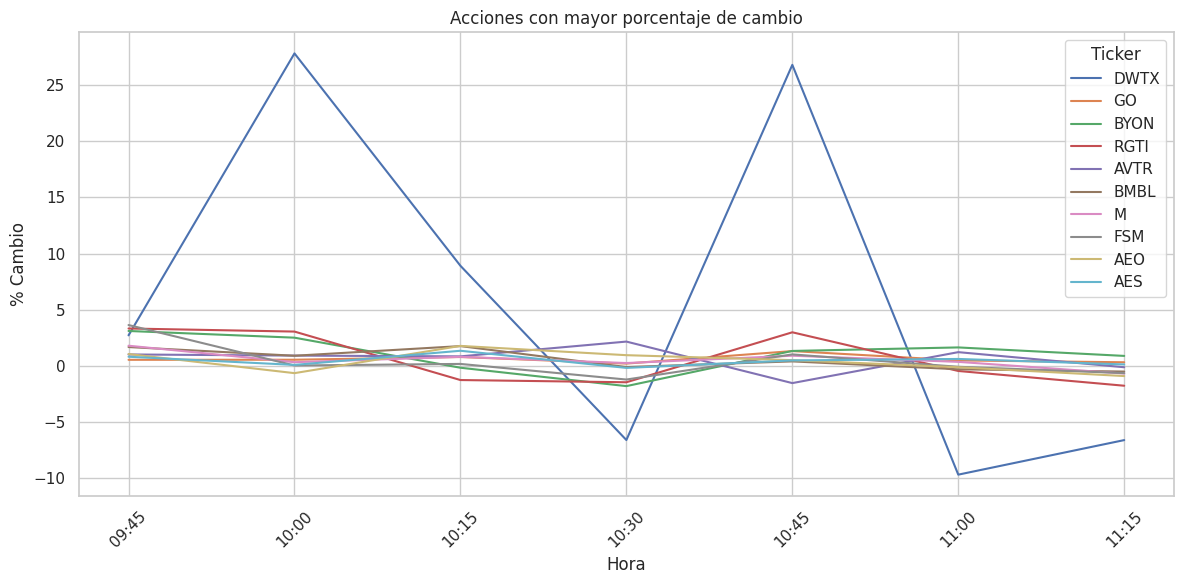

In [469]:
# Seleccionar las 5 acciones de mayor cambio
df_cambio_jornada_gr = df_cambio_jornada.head(10)

# Filtrar dataframe para que contenga solo los tickers de mayor cambio
df_grafico = df_final[df_final['Ticker'].isin(df_cambio_jornada_gr['Ticker'])].copy()  # Crear copia

# Conservar la hora del campo Fecha
df_grafico['Fecha'] = df_grafico['Fecha'].astype(str).apply(lambda x: x.split(' ')[1][:5])

# Grafica
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grafico, x='Fecha', y='%_cambio', hue='Ticker', marker=None)

# Ajustes del gráfico
plt.title('Acciones con mayor porcentaje de cambio')
plt.xlabel('Hora')
plt.ylabel('% Cambio')
plt.xticks(rotation=45)
plt.legend(title='Ticker')
plt.tight_layout()

# Muestra el gráfico
plt.show()

##Graficar comportamiento: 2-Precio

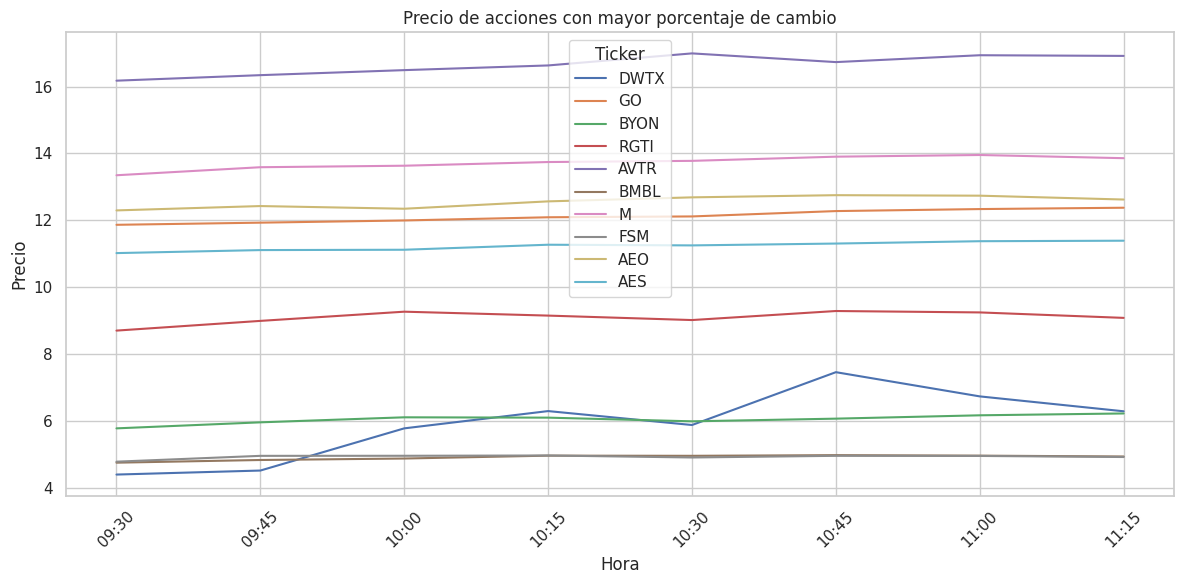

In [470]:
# Grafica
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grafico, x='Fecha', y='Close', hue='Ticker', marker=None)

# Ajustes del gráfico
plt.title('Precio de acciones con mayor porcentaje de cambio')
plt.xlabel('Hora')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.legend(title='Ticker')
plt.tight_layout()

# Muestra el gráfico
plt.show()